# Gecko dataset modelling

In [213]:
# Import required packages
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error

In [224]:
def prepare_data(path: Path, features: list, target: list=None):
    """Load data from the given path, select required features, preprocess the data
    and if needed select the target
    """
    dataset = pd.read_csv(path)
    if not target:
        # Test dataset lacks this column, but it is present in the training set
        dataset["ohe_parentspecies_decane_toluene"] = 0.0

    x = dataset[features]
    
    # One hot encoding of parentspecies column has Nan values, 
    # I decided to keep the rows with Nans and set each of the ohe* variables to one 
    x[x[["ohe_parentspecies_apin",
    "ohe_parentspecies_apin_decane",
    "ohe_parentspecies_apin_decane_toluene",
    "ohe_parentspecies_apin_toluene",
    "ohe_parentspecies_decane",
    "ohe_parentspecies_decane_toluene"]].isna()] = 1.0

    # id column is not a meanigful feature
    x = x.drop("id", axis=1)
    if target:
        y = dataset[target]
        return x, y
    else:
        return x
    
def transform_predictions(predictions):
    """Reverse transformation applied to the target variable. First unscales the variable based on the mean and std values from the training set
    then applies exp function. Verified to work properly on the train set."""
    df = pd.read_csv("data/train.csv")
    orig_log_mean = np.log(df["pSat_Pa"]).mean()
    orig_log_std = np.log(df["pSat_Pa"]).std()
    unscaled = unscale(predictions, orig_log_mean, orig_log_std)
    return np.exp(unscaled)

def unscale_orig_target(target):
    """Unscale the value of pSat_Pa to obtain the original values. Verified to work properly for the train set."""
    df = pd.read_csv("data/train.csv")
    orig_mean = df["pSat_Pa"].mean()
    orig_std = df["pSat_Pa"].std()
    return unscale(target, orig_mean, orig_std)

def unscale(variable, mean, std):
    return std * variable + mean

def scale(variable, mean, std):
    return (variable - mean) / std

def save_test_predictions(test_predictions, save_path, original_test_file):
    original_test = pd.read_csv(original_test_file)
    original_test["target"] = test_predictions
    original_test["Id"] = original_test["id"]
    result = original_test[["Id", "target"]]
    result.to_csv(save_path, index=False)

def cross_validate_model(model, x, y, cv=10, scoring='r2'):
    scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return scores.mean()

In [170]:
features = ['id', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN',
       'NumHBondDonors', 'NumOfConfUsed', 'cc', 'ccco',
       'hydroxyl_alkl', 'aldehyde', 'ketone', 'carboxylic_acid', 'ester',
       'ether_alicyclic', 'nitrate', 'nitro', 'aromatic_hydroxyl',
       'carbonylperoxynitrate', 'peroxide', 'hydroperoxide',
       'carbonylperoxyacid', 'nitroester', 'trans_NumOfConf',
       'trans_MW',
       'ohe_parentspecies_apin', 'ohe_parentspecies_apin_decane',
       'ohe_parentspecies_apin_decane_toluene',
       'ohe_parentspecies_apin_toluene', 'ohe_parentspecies_decane',
       'ohe_parentspecies_decane_toluene']
target = ['pSat_Pa', 'trans_pSat_Pa']

data_dir = Path("data")
train_data_path = data_dir / "gecko_ml.csv"
test_data_path = data_dir / "gecko_ml_test.csv"
original_x, original_y = prepare_data(train_data_path, features, target=target)
x, y = prepare_data(train_data_path, features, target=target)
x_test = prepare_data(test_data_path, features)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

y_train_org = y_train[target[0]]
y_train_trans = y_train[target[1]]
y_train_log10 = np.log10(unscale_orig_target(y_train_org))
y_train_log10_scaled = scale(y_train_log10, y_train_log10.mean(), y_train_log10.std())

y_val_org = y_val[target[0]]
y_val_trans = y_val[target[1]]
y_val_log10 = np.log10(unscale_orig_target(y_val_org))
y_val_log10_scaled = scale(y_val_log10, y_val_log10.mean(), y_val_log10.std())

x, y = shuffle(x, y)
y_org = y[target[0]]
y_trans = y[target[1]]
y_log10 = np.log10(unscale_orig_target(y_org))
y_log10_scaled = scale(y_log10, y_log10.mean(), y_log10.std())


/tmp/ipykernel_32217/1962207925.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_parentspecies_apin",
/tmp/ipykernel_32217/1962207925.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["ohe_parentspecies_apin",
/tmp/ipykernel_32217/1962207925.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[x[["oh

    
### Dataset columns descriptions

##### Original variables that were scaled:
- **id** - A unique molecule index used in naming files

- **pSat_Pa** - The saturation vapour pressure of the molecule calculated by COSMOtherm (Pa)
- **MW** - The molecular weight of the molecule (g/mol).
- **NumOfAtoms** - The number of atoms in the molecule
- **NumOfC** - The number of carbon atoms in the molecule
- **NumOfO** - The number of oxygen atoms in the molecul
- **NumOfN** - The number of nitrogen atoms in the molecule
- **NumHBondDonors** - “The number of hydrogen bond donors in the molecule, i.e. hydrogens bound to oxygen.”
- **NumOfConf** - The number of stable conformers found and successfully calculated by COSMOconf.
- **NumOfConfUsed** - The number of conformers used to calculate the thermodynamic properties.

- **cc** - The number of non-aromatic C=C bounds found in the molecule.
- **ccco** - The number of “C=C-C=O” structures found in non-aromatic rings in the molecule.
- **hydroxyl_alkl** - The number of the alkylic hydroxyl groups found in the molecule.
- **aldehyde** - The number of aldehyde groups in the molecule.
- **ketone** - The number of ketone groups in the molecule.

- **carboxylic_acid** - The number of carboxylic acid groups in the molecule.
- **ester** - The number of ester groups in the molecule.
- **ether_alicyclic** - The number of alicyclic ester groups in the molecule.
- **nitrate** - The number of alicyclic nitrate groups in the molecule
- **nitro** - The number of nitro ester groups in the molecule
- **aromatic_hydroxyl** - The number of alicyclic aromatic hydroxyl groups in the molecule.
- **carbonylperoxynitrate** - The number of carbonylperoxynitrate groups in the molecule.
- **peroxide** - The number of peroxide groups in the molecule
- **hydroperoxide** - The number of hydroperoxide groups in the molecule.
- **carbonylperoxyacid** - The number of carbonylperoxyacid groups found in the molecule
- **nitroester** - The number of nitroester groups found in the molecule
- **parentspecies** - Either “decane”, “toluene”, “apin” for alpha-pinene or a combination of these connected by an underscore to indicate ambiguous descent. In 243 cases, the parent species is “None” because it was not possible to retrieve it.
    

##### Transformed or created variables (also scaled):
                
- **trans_NumOfConf**,    # NumOfConf to the power of 0.3           
- **trans_MW**,           # Square root of trans_MW              
- **trans_pSat_Pa**,      # log transformed pSat_Pa                  
- **new_MW_hydroxyl_alkl_interaction**, #interaction term between MW and hydroxyl_alkl
- **new_polarity_score**,  #polarity with assigning different weights to functional group features               
- **new_num_pca_1**,      #First principal component for all variable with "Num" in names               
- **new_num_pca_2**,      #Second principal component for all variable with "Num" in names                  

#### Variables for the one hot encoding for parentspecies:
- **ohe_parentspecies_apin**,               # parentspecies category apin
- **ohe_parentspecies_apin_decane**,        # parentspecies category decane
- **ohe_parentspecies_apin_decane_toluene**,# parentspecies category apin_decane_toluene
- **ohe_parentspecies_apin_toluene**,       # parentspecies category apin_toluene
- **ohe_parentspecies_decane**,             # parentspecies category decane
- **ohe_parentspecies_decane_toluene**,     # parentspecies category decane_toluene

# Model selection


In [228]:
lin_reg = LinearRegression()
elasticnet = ElasticNet(alpha=0.003, l1_ratio=1)
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()

In [173]:
scores = cross_val_score(lin_reg, x, y_log10, cv=10, scoring='r2')
print(scores.mean())

0.7095661569053759


In [219]:
elasticnetcv = ElasticNetCV(cv=10)
elasticnetcv.fit(x.to_numpy(), y_log10.to_numpy())
print(elasticnetcv.alpha_, elasticnetcv.l1_ratio_)

0.0030016018911636893 0.5


In [229]:
scores = cross_val_score(elasticnet, x, y_log10, cv=10, scoring='r2')
print(scores.mean())

0.7079953226407778


In [174]:
scores = cross_val_score(rf, x, y_log10, cv=10, scoring='r2')
print(scores.mean())

0.7165979435672526


In [176]:
scores = cross_val_score(svr, x, y_log10, cv=10, scoring='r2')
print(scores.mean())

0.7475439245520384


In [175]:
scores = cross_val_score(gbr, x, y_log10, cv=10, scoring='r2')
print(scores.mean())


0.7240028565283071


In [221]:
lin_reg.fit(x, y_log10)

LinearRegression()

[ 1.14148078e+00 -1.28795673e+00  1.18596877e+00  2.75097655e+11
  1.10367931e+11  1.18437735e-01 -1.03238933e-01  2.31159347e-03
 -9.42531158e+10 -9.13101841e-02  6.03047712e-02 -5.73431870e+10
 -1.81827099e-01 -2.29384939e-01 -2.60023068e+11 -1.41465136e+11
 -5.09073151e+09 -1.74358481e+11 -5.62652084e-01 -7.56596966e+10
 -5.05910178e+10  5.60722466e-03 -6.81852776e-01 -9.52413547e-01
 -1.54636602e-03 -3.85981473e-01 -3.62054975e-01 -1.22185960e-01
 -5.23247177e-01  7.14952677e-01]


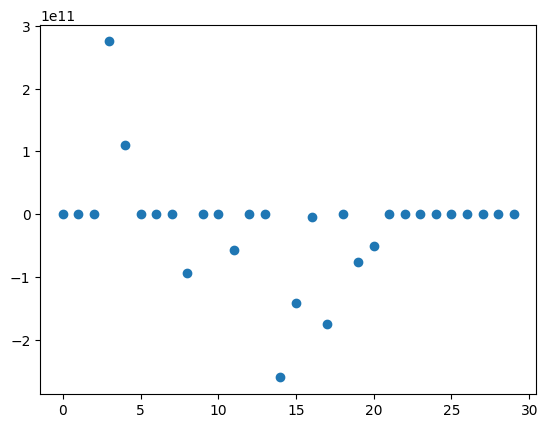

In [227]:
to_plot = lin_reg.coef_
print(to_plot)
plt.scatter(np.arange(to_plot.size), to_plot)

In [230]:
elasticnet.fit(x, y_log10)

ElasticNet(alpha=0.003, l1_ratio=1)

[ 0.43725588 -1.06001012  0.          0.         -1.10721032  0.09717644
 -0.16026404 -0.00245045  0.         -0.          0.16611957 -0.29245287
 -0.02004181 -0.15739837  0.         -0.00983853 -0.02663001  0.33564678
 -0.29005366 -0.16091368 -0.11001858  0.04391152 -0.54919016 -0.20528496
 -0.         -0.         -0.         -0.         -0.47154775 -0.        ]


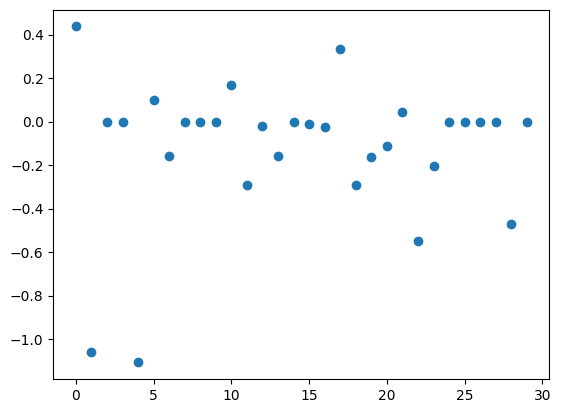

In [231]:
to_plot = elasticnet.coef_
print(to_plot)
plt.scatter(np.arange(to_plot.size), to_plot)

In [232]:
importantfeats = original_x.columns[np.abs(to_plot) > 0.05]
print(importantfeats)

Index(['NumOfAtoms', 'NumOfC', 'NumHBondDonors', 'NumOfConfUsed', 'cc',
       'ketone', 'carboxylic_acid', 'ether_alicyclic', 'carbonylperoxynitrate',
       'peroxide', 'hydroperoxide', 'carbonylperoxyacid', 'trans_NumOfConf',
       'trans_MW', 'ohe_parentspecies_decane'],
      dtype='object')


In [234]:
cross_validate_model(rf, x[importantfeats], y_log10)

0.7050401231442326

In [235]:
rf.fit(x[importantfeats], y_log10)

RandomForestRegressor()

In [238]:
preds = rf.predict(x_test[importantfeats])
save_test_predictions(preds, "rf_selected_feats_log10.csv", test_data_path)

In [239]:
svr.fit(x[importantfeats], y_log10)

SVR()

In [240]:

preds = svr.predict(x_test[importantfeats])
answ = unscale(preds, y_log10.mean(), y_log10.std())
save_test_predictions(preds, "predictions/svr_selected_feats_log10.csv", test_data_path)